## Laboratorio ViT Parte 2

En este laboratorio, exploraremos el proceso de fine-tuning de un modelo Vision Transformer ya preentrenado. Resolveremos la tarea de clasificación utilizando el conjunto de datos CIFAR-10. Consta de 60,000 imágenes a color de 32x32 píxeles, distribuidas en 10 clases con 6000 imágenes por clase. Observaremos cómo ajustar los parámetros de un modelo preentrenado puede acelerar significativamente tanto el rendimiento como el tiempo de entrenamiento cuando se adapta específicamente a las características de CIFAR-10.

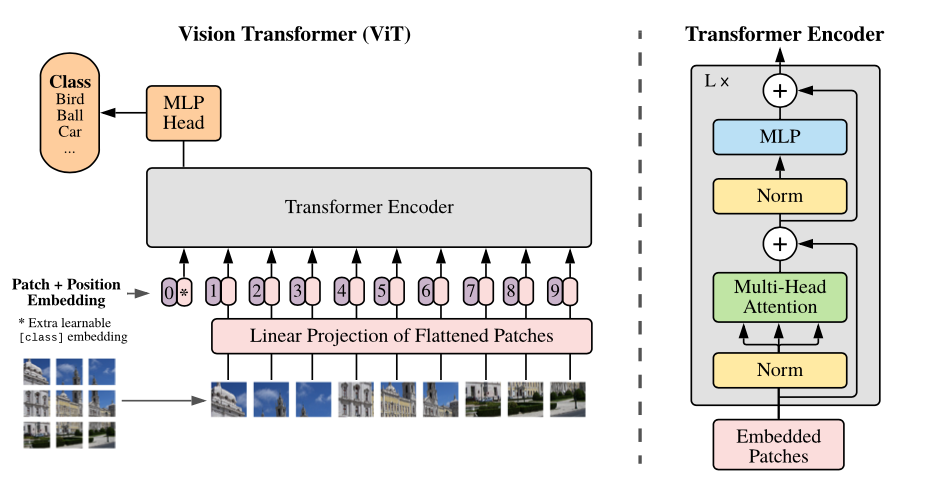

* Paper: https://arxiv.org/abs/2010.11929



## 1.0 Carga de datos y Hugging Face

Aquí cargamos CIFAR-10, un famoso conjunto de datos de clasificación de imágenes, desde  el hub de Hugging Face.

Hugging Face es una plataforma y comunidad de machine learning y ciencia de datos que ayuda a los usuarios a construir, implementar y entrenar modelos de machine learning. Funciona como un hub donde los expertos y entusiastas de la IA pueden compartir, probar y colaborar en modelos y conjuntos de datos.  Hugging Face es reconocido por su biblioteca de Transformers en Python, que simplifica la descarga y entrenamiento de modelos de aprendizaje automático. La plataforma es esencial debido a su naturaleza de código abierto y herramientas de implementación, permitiendo a los usuarios compartir recursos, modelos e investigaciones para reducir el tiempo de entrenamiento del modelo y el impacto ambiental del desarrollo de la IA. Hugging Face Inc. fue fundada en 2016 en Nueva York por Clément Delangue, Julien Chaumond y Thomas Wolf.

Haciendo click en el [enlace](https://huggingface.co/datasets/cifar10) puedes ver todos los ejemplos de la base de datos directamente en tu navegador. En el laboratorio anterior discutimos acerca de esta base de datos. por qué es retadora para muchos modelos de visión por computador y por qué se utiliza como un benchmark.

In [1]:
from datasets import load_dataset


# Cargamos cifar10 (solo una pequeña porción con fines de demostración).
train_ds, test_ds = load_dataset('cifar10', split=['train[:2500]', 'test[:500]'])
# Dividimos la base de datos en losconjuntos de entrenamiento y validación.
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

En la siguiente celda podemos ver que cada imágen tiene asociada una etiqueta y que tenemos 2250 imágenes de entrenamiento. Note que son pocos datos de entrenamiento si lo comparamos con la cantidad de datos que necesitamos en el laboratorio anterior para entrenar el modelo preentrenado (12500 imágenes de entrenamiento).

In [2]:
#Imprimimos cuántos datos tenemos
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 2250
})

También podemos examinar las características de la base de datos con más detalle. En la siguiente celda podemos ver nuevamente las 10 etiquetas de la base de datos CIFAR10.

In [3]:
#Vemos las etiquetas
train_ds.features

{'img': Image(decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

Veamos un ejemplo de un dato del conjunto de datos de entrenamiento y su etiqueta:

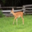

In [12]:
#Vemos una imagen de entrenamiento
train_ds[100]['img']

In [13]:
train_ds[100]['label']

4

Acá podemos ver qué clase corresponde a qué número de clase:

In [14]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [16]:
id2label[train_ds[100]['label']]

'deer'

## 2.0  Preprocesamiento de los datos: Data Augmentation

Igual que en laboratorio anterior tendremos que implementar la técnica de data augmentation para nuestros datos de entranamiento. Recuerde que el aumento de datos, o data augmentation, implica expandir artificialmente el conjunto de entrenamiento mediante modificaciones de los datos existentes, como rotaciones o cambios de tamaño en imágenes. Es esencial en el aprendizaje profundo para prevenir el sobreajuste y mejorar la diversidad del conjunto de datos.

Realizaremos la aumentación de datos utilizando el método `set_transform` de HuggingFace Datasets. La documentación se encuentra [aquí](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform).

In [17]:
#Importamos la librería para preprocesar imágenes
from transformers import ViTImageProcessor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Para la aumentación de datos (data augmentation)  utilizaremos el módulo de transformaciones de torchvision, que se encuentra [aquí](https://pytorch.org/vision/0.9/transforms.html). En este caso utilizaremos transformaciones como crops o recortes de las imágenes, normalizaremos las imágenes, haremos también rotaciones aleatorias y recortes aleatorios.

In [18]:
#Importamos las transformaciones que utilizaremos.
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)
#Encontramos estadísticos de las imágenes para normalizarlas.
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
#Normalizamos las imágenes.
normalize = Normalize(mean=image_mean, std=image_std)
#Componemos todas las transformaciones que utilizaremos para los datos de entrenamiento.
#Solo podemos aplicar rotaciones aleatorias en el conjunto de entrenamiento.
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )
#Para el conjunto de validación únicamente alteraremos sus dimensiones y las normalizaremos.
#No aplicaremos rotaciones a las imágenes de validación, pues se espera que queremos evaluar cómo
#se comportará el modelo al observar datos reales que no ha visto.
_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )
#Definimos funciones que aplican las transformaciones a las bases de datos.
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [19]:
# Le aplicamos las transformaciones a las bases de datos
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

Tras aplicar todas las transformaciones, podemos ver que ahora nuestras imágenes son tensores numéricos de 32x32x3. También podemos ver las etiquetas. Note que todos los valores ya están normalizados.

In [20]:
train_ds[:1]

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>],
 'label': [6],
 'pixel_values': [tensor([[[-0.9765, -0.9765, -0.9765,  ...,  0.0980,  0.0980,  0.0980],
           [-0.9765, -0.9765, -0.9765,  ...,  0.0980,  0.0980,  0.0980],
           [-0.9765, -0.9765, -0.9765,  ...,  0.0980,  0.0980,  0.0980],
           ...,
           [-0.9451, -0.9451, -0.9451,  ..., -0.2314, -0.2314, -0.2314],
           [-0.9451, -0.9451, -0.9451,  ..., -0.2314, -0.2314, -0.2314],
           [-0.9451, -0.9451, -0.9451,  ..., -0.2314, -0.2314, -0.2314]],
  
          [[-0.9608, -0.9608, -0.9608,  ..., -0.6941, -0.6941, -0.6941],
           [-0.9608, -0.9608, -0.9608,  ..., -0.6941, -0.6941, -0.6941],
           [-0.9608, -0.9608, -0.9608,  ..., -0.6941, -0.6941, -0.6941],
           ...,
           [-0.9373, -0.9373, -0.9373,  ..., -0.2000, -0.2000, -0.2000],
           [-0.9373, -0.9373, -0.9373,  ..., -0.2000, -0.2000, -0.2000],
           [-0.9373, -0.9373, -0.9373,  ..., -0.2000, -0.20

## 2.1 Data Loader 

Ahora, crearemos un Data Loader en PyTorch.

Un data loader, en el contexto de bibliotecas como PyTorch, es una herramienta esencial para la carga eficiente de datos durante el entrenamiento de modelos de aprendizaje profundo. Su función principal es gestionar la iteración sobre un conjunto de datos, dividiéndolo en batches para su procesamiento. La utilidad clave del data loader está en su capacidad para cargar datos en paralelo, lo que mejora significativamente la eficiencia, especialmente al tratar con conjuntos de datos grandes. Además, el data loader ofrece características como aleatorización de datos y manipulación sencilla de batches, lo que es crucial para prevenir el sobreajuste del modelo y mejorar su capacidad de generalización.

Para leer más acerca sobre data loaders dirijase a la [documentación](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [21]:
#Importamos la librería de DataLoader
from torch.utils.data import DataLoader
import torch

# Definición de la función collate_fn que será utilizada por el DataLoader
def collate_fn(examples):
    # Apila los valores de píxeles de todas las imágenes en el batch
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    # Crea un tensor para las etiquetas a partir de la lista de etiquetas
    labels = torch.tensor([example["label"] for example in examples])
    # Retorna un diccionario con los valores de píxeles y las etiquetas para el lote
    return {"pixel_values": pixel_values, "labels": labels}

# Creación del DataLoader de entrenamiento (train_dataloader)
# Se utiliza el DataLoader para cargar los datos en batches durante el entrenamiento
# Se especifica el tamaño del lote (batch_size=4), cada lote contendrá 4 imágenes
# Se utiliza la función collate_fn para definir cómo combinar las muestras individuales en un lote
train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)


## 3.0 Creación del modelo

Descargaremos un Vision Transformer preentrenado de Hugging Face específicamente la variante "vit-base-patch16-224-in21k". Este modelo es un modelo de codificación tipo transformer preentrenado en una amplia colección de imágenes de manera supervisada, en particular en ImageNet-21k, que contiene 14 millones de imágenes con 21,843 clases.
Las imágenes se presentan al modelo como una secuencia de parches de tamaño fijo (resolución 16x16).

El modelo se entrenó en hardware TPUv3 (8 núcleos) con un tamaño de batch de 4096 y una resolución de preentrenamiento de 224x224. Los detalles adicionales sobre la evaluación y la citación se proporcionan en la  [documentación](https://huggingface.co/google/vit-base-patch16-224-in21k).

In [22]:
from transformers import ViTForImageClassification
#Importamos el modelo
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4.0 Entrenamiento del modelo preentrenado 

Vamos a crear una instancia del objeto `Trainer`. Este componente pertenece a la biblioteca `Transformers` y facilitará el proceso de entrenamiento de nuestro modelo. En esta etapa, estableceremos la métrica de entrenamiento que emplearemos, que será la precisión, como hemos utilizado en laboratorios previos. Además, configuraremos la clase `TrainingArguments`, que contiene todos los atributos necesarios para personalizar el entrenamiento. Aquí, definiremos los hiperparámetros clave para el proceso, tales como la tasa de aprendizaje, el número de épocas, los tamaños de los batches de entrenamiento y validación, así como el parámetro de weight decay. Estos hiperparámetros han sido discutidos con anterioridad en laboratorios anteriores.

In [26]:
# Importamos las clases TrainingArguments y Trainer de la biblioteca Transformers
from transformers import TrainingArguments, Trainer

# Definimos el nombre de la métrica que utilizaremos para el entrenamiento, en este caso, "accuracy"
metric_name = "accuracy"

# Configuramos los argumentos de entrenamiento mediante la instancia de TrainingArguments
args = TrainingArguments(
    "test-cifar-10",  # Nombre del directorio donde se guardarán los resultados del entrenamiento
    save_strategy="epoch",  # Estrategia de guardado: en este caso, guardaremos modelos al final de cada época
    evaluation_strategy="epoch",  # Estrategia de evaluación: evaluaremos el modelo al final de cada época
    learning_rate=2e-5,  # Tasa de aprendizaje para el optimizador
    per_device_train_batch_size=10,  # Tamaño del batch por dispositivo para el entrenamiento
    per_device_eval_batch_size=4,  # Tamaño del batch por dispositivo para la evaluación
    num_train_epochs=3,  # Número total de épocas de entrenamiento
    weight_decay=0.01,  # Parámetro de weight decay para prevenir el sobreajuste
    load_best_model_at_end=True,  # Cargar el mejor modelo al final del entrenamiento
    metric_for_best_model=metric_name,  # Métrica utilizada para determinar el mejor modelo
    logging_dir='logs',  # Directorio donde se almacenarán los registros del entrenamiento
    remove_unused_columns=False,  # No eliminar columnas no utilizadas del conjunto de datos
)


En la siguiente celda definiremos la métrica de entrenamiento:

In [27]:
# Importamos las bibliotecas necesarias
from sklearn.metrics import accuracy_score
import numpy as np

# Definimos una función para calcular métricas a partir de las predicciones de evaluación
def compute_metrics(eval_pred):
    # Desempaquetamos las predicciones y las etiquetas verdaderas del objeto eval_pred
    predictions, labels = eval_pred

    # Convertimos las predicciones en etiquetas predichas tomando el índice del valor máximo en cada fila. Es decir, escogemos la clase con la más alta probabilidad.
    predictions = np.argmax(predictions, axis=1)

    # Calculamos la precisión comparando las etiquetas predichas con las etiquetas verdaderas
    return dict(accuracy=accuracy_score(predictions, labels))


Pasamos todos estos parámetros junto con nuestros conjuntos de datos al Trainer:

In [28]:
# Creamos un objeto Trainer para facilitar el proceso de entrenamiento
trainer = Trainer(
    model=model,                     # Modelo a entrenar
    args=args,                       # Argumentos de entrenamiento personalizados
    train_dataset=train_ds,          # Conjunto de datos de entrenamiento
    eval_dataset=val_ds,             # Conjunto de datos de evaluación
    data_collator=collate_fn,        # Función para la recopilación de datos
    compute_metrics=compute_metrics, # Función para calcular métricas
    tokenizer=processor,             # Tokenizador asociado al modelo
)


Ahora podemos hacer finetuning a nuestro modelo simplemente llamando al método `train`. En la siguiente celda entrenaremos a nuestro modelo preentrenado con los datos que tomamos de CIFAR10. En la siguiente tabla podemos ver el desempeño de nuestro modelo durante el entrenamiento. Podemos observar que con tan solo 3 épocas y utilizando tan solo 4500 imágenes de entrenamiento logramos obtener una precisión mayor al 95%.

In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.386276,0.944000
2,No log,0.940747,0.968000
3,1.507400,0.829923,0.968000


TrainOutput(global_step=675, training_loss=1.3631237114800347, metrics={'train_runtime': 194.1723, 'train_samples_per_second': 34.763, 'train_steps_per_second': 3.476, 'total_flos': 5.23108434852864e+17, 'train_loss': 1.3631237114800347, 'epoch': 3.0})

## 5.0 Evaluación del modelo y matriz de confusión 

Finalmente, evaluemos el desempeño de neustro modelo en el conjunto de prueba: 

In [30]:
outputs = trainer.predict(test_ds)

In [31]:
print(outputs.metrics)

{'test_loss': 0.9458701014518738, 'test_accuracy': 0.95, 'test_runtime': 15.6156, 'test_samples_per_second': 32.019, 'test_steps_per_second': 8.005}


Una matriz de confusión es una técnica para resumir el rendimiento de un algoritmo de clasificación. Aunque la métrica de precisión de la clasificación puede proporcionar una medida general del rendimiento, puede ser engañosa en casos de clases desbalanceadas o cuando hay más de dos clases en el conjunto de datos. La matriz de confusión desglosa los resultados de las predicciones y los clasifica por cada clase, proporcionando una visión más detallada del rendimiento del modelo de clasificación.

La matriz de confusión muestra la cantidad de predicciones correctas e incorrectas, detallando cómo el modelo se confunde al realizar predicciones. Esta descomposición no solo revela los errores cometidos por el clasificador, sino, lo que es más importante, los tipos de errores que se están cometiendo.

La construcción de una matriz de confusión implica:





1.   Contar el número de predicciones correctas para cada clase y el número de predicciones incorrectas, organizados por la clase que fue predicha.
2.   La matriz de confusión se organiza en una tabla o matriz donde las etiquetas esperadas se encuentran en el eje vertical y las predicciones se encuentran en el eje horizontal. Los recuentos de clasificaciones correctas e incorrectas se completan en la tabla.

Cómo leerla e interpretarla:

En una matriz de confusión, contamos la clase a la que se predice que pertenece cada elemento (columnas) según su clase real (filas). De esta manera, en la diagonal, encontraremos los elementos que fueron clasificados correctamente (la clase predicha coincide con la clase real), mientras que en los elementos fuera de la diagonal, veremos el número de elementos clasificados incorrectamente. Cuantos más elementos haya en la diagonal, mejor será nuestro clasificador. Si observamos las columnas, podemos ver, para cada clase predicha, cuáles fueron las clases reales. Si observamos las filas, podemos ver, para cada clase real, cuáles fueron las clases predichas.







In [ ]:
# Importamos las bibliotecas necesarias para evaluar y visualizar la matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Obtenemos las etiquetas reales y predichas del conjunto de datos de evaluación
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# Obtenemos las etiquetas disponibles en el conjunto de datos
labels = train_ds.features['label'].names

# Calculamos la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Creamos un objeto ConfusionMatrixDisplay para visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Mostramos la visualización de la matriz de confusión con rotación de las etiquetas en el eje x
disp.plot(xticks_rotation=45)
plt.show()

**IMPORTANTE** Ahora que has completado todas las tareas del laboratorio, lo siguiente es responder a un cuestionario en la siguiente actividad. Este cuestionario te permitirá evaluar y poner a prueba tu comprensión de los conceptos abordados en este laboratorio.

In [ ]:
### BEGGIN HIDDEN TESTS

x=True

assert x==True, 'Completaste el laboratorio con éxito'
